Fit linear models predicting female behavior from surrogate neural activity.

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model
import sys

from disp import set_plot
from my_torch import skl_fit_ridge

cc = np.concatenate


TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

PFX_BHV = f'data/simple/behav_xtd/behav_xtd'

COLS_USE = ['T']

PTRAIN = .8
NSPLIT = 30

NSPLIT_SAVE_Y_HAT = 5

MASK_PFX = 'data/simple/masks/mask'

ALPHA = 10

if MASK_PFX:
    FSAVE_SFX = f'{TARG_BHV.lower()}_masked'
else:
    FSAVE_SFX = f'{TARG_BHV.lower()}'

In [2]:
STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()
NTRAIN = int(round(PTRAIN*NTR))

In [3]:
pfx_nrl = f'data/simple/mlv/lin_filter/rc_lin/rc_lin'  # use some neural file that includes timestamp

fsave = f'data/simple/mlv/heuristic/time_{STRAIN_KEY}_{FSAVE_SFX}.npy'

# fit regression models
rslts = skl_fit_ridge(
    pfxs=[pfx_nrl, PFX_BHV],
    cols_x=COLS_USE,
    targs=TARGS,
    itr_all=ISTRAIN,
    ntrain=NTRAIN,
    nsplit=NSPLIT,
    mask_pfx=MASK_PFX,
    return_y=np.arange(NSPLIT_SAVE_Y_HAT),
    alpha=ALPHA)

# save r2, weights, and example predictions
save_data = {
    'r2_train': {targ: np.array([rslt.r2_train[targ] for rslt in rslts]) for targ in TARGS},
    'r2_test': {targ: np.array([rslt.r2_test[targ] for rslt in rslts]) for targ in TARGS},

    'ys_train': {targ: [rslt.ys_train[targ] for rslt in rslts if rslt.ys_train] for targ in TARGS},
    'ys_test': {targ: [rslt.ys_test[targ] for rslt in rslts if rslt.ys_train] for targ in TARGS},

    'y_hats_train': {targ: [rslt.y_hats_train[targ] for rslt in rslts if rslt.ys_train] for targ in TARGS},
    'y_hats_test': {targ: [rslt.y_hats_test[targ] for rslt in rslts if rslt.ys_train] for targ in TARGS},
    
    'targs': TARGS,
    'alpha': ALPHA,

    'ntr': NTR,
    'ntrain': NTRAIN,
    'nsplit': NSPLIT,
}

np.save(fsave, np.array([save_data]))

Loading...

Split 0
Split 1
Split 2
Split 3
Split 4
Split 5
Split 6
Split 7
Split 8
Split 9
Split 10
Split 11
Split 12
Split 13
Split 14
Split 15
Split 16
Split 17
Split 18
Split 19
Split 20
Split 21
Split 22
Split 23
Split 24
Split 25
Split 26
Split 27
Split 28
Split 29

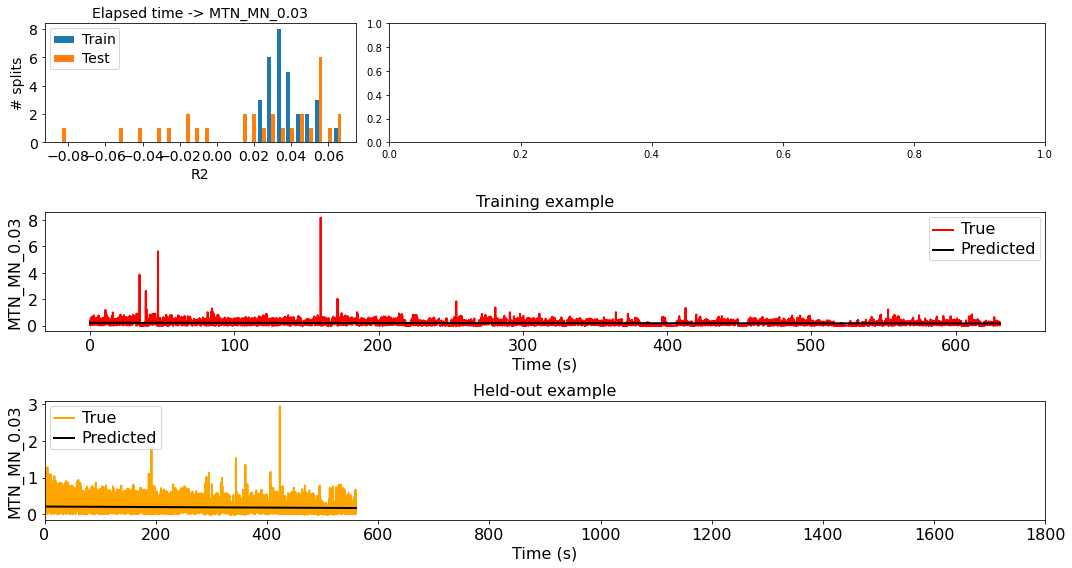

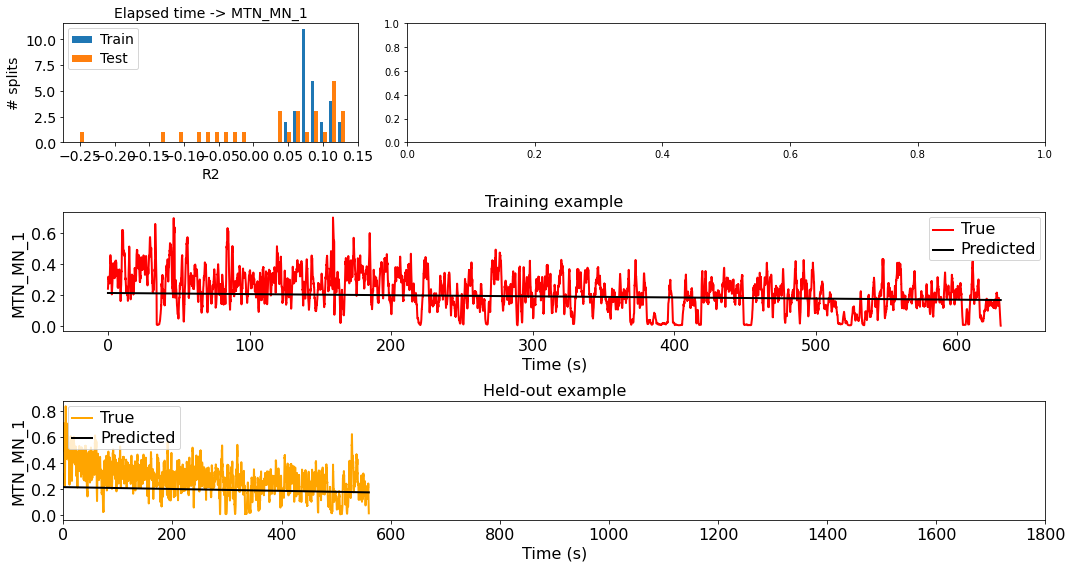

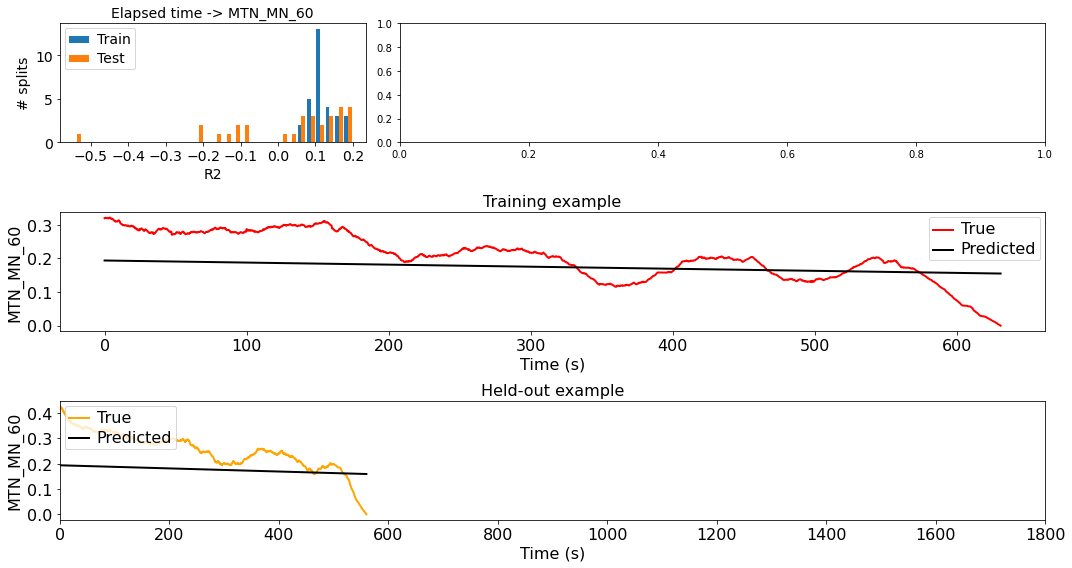

In [4]:
ISPLIT = 0
ITRAIN_PLOT = 1
ITEST_PLOT = 1

FPS = 30.03

fsave = f'data/simple/mlv/heuristic/time_{STRAIN_KEY}_{FSAVE_SFX}.npy'

data = np.load(fsave, allow_pickle=True)[0]

for targ in TARGS:

    r2_train = data['r2_train'][targ]
    r2_test = data['r2_test'][targ]

    gs = gridspec.GridSpec(3, 3)

    fig = plt.figure(figsize=(15, 8), tight_layout=True)
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1:]), fig.add_subplot(gs[1, :]), fig.add_subplot(gs[2, :])]

    axs[0].hist(np.transpose([r2_train, r2_test]), bins=30)
    axs[0].legend(['Train', 'Test'])

    set_plot(axs[0], x_label='R2', y_label='# splits', title=f'Elapsed time -> {targ}', font_size=14)

    y_train = data['ys_train'][targ][ISPLIT][ITRAIN_PLOT]
    t_train = np.arange(len(y_train))/FPS

    y_hat_train = data['y_hats_train'][targ][ISPLIT][ITRAIN_PLOT]

    axs[2].plot(t_train, y_train, c='r', lw=2)
    axs[2].plot(t_train, y_hat_train, c='k', lw=2)

    axs[2].legend(['True', 'Predicted'])

    set_plot(axs[2], x_label='Time (s)', y_label=targ, title='Training example', font_size=16)

    y_test = data['ys_test'][targ][ISPLIT][ITEST_PLOT]
    t_test = np.arange(len(y_test))/FPS

    y_hat_test = data['y_hats_test'][targ][ISPLIT][ITEST_PLOT]

    axs[3].plot(t_test, y_test, c='orange', lw=2)
    axs[3].plot(t_test, y_hat_test, c='k', lw=2)

    axs[3].legend(['True', 'Predicted'], loc='upper left')

    set_plot(axs[3], x_lim=(0, 1800), x_label='Time (s)', y_label=targ, title='Held-out example', font_size=16)